In [1]:
## IMPORTS 
import evotoon
from data_classes import CatParam, IntParam, FloatParam

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns#

import random
import warnings
warnings.filterwarnings("ignore")

## MAKE SEED
SEED = evotoon.make_seed(465)

In [2]:
def get_best_confs(folder):
	cols = ["alpha", "beta", "rho", "ants", "nnls", "elitistants", "localsearch", "dlb", "Step_Found", "VALUE"]

	df = pd.DataFrame()
	for file in sorted(os.listdir(folder)):
		path = folder + file
		df = df.append(pd.read_csv(path, usecols= cols, sep='\t').iloc[0])

	return df.reset_index(drop=True)

def run_acotsp(save_folder, seed, alpha, beta, rho, ants, nnls, elitistants, localsearch, dlb):
	instance_list = [
		"./ALL_tsp/a280.tsp",
		"./ALL_tsp/ali535.tsp",
		"./ALL_tsp/att48.tsp",
		"./ALL_tsp/d1655.tsp",
		"./ALL_tsp/eil101.tsp",
		"./ALL_tsp/eil51.tsp",
		"./ALL_tsp/gr202.tsp",
		"./ALL_tsp/gr229.tsp",
		"./ALL_tsp/gr431.tsp",
		"./ALL_tsp/gr666.tsp",
		"./ALL_tsp/kroA150.tsp",
		"./ALL_tsp/kroB100.tsp",
		"./ALL_tsp/kroB150.tsp",
		"./ALL_tsp/kroB200.tsp",
		"./ALL_tsp/p654.tsp",
		"./ALL_tsp/pcb1173.tsp",
		"./ALL_tsp/pr124.tsp",
		"./ALL_tsp/pr136.tsp",
		"./ALL_tsp/pr264.tsp",
		"./ALL_tsp/pr76.tsp",
		"./ALL_tsp/rat575.tsp",
		"./ALL_tsp/rat99.tsp",
		"./ALL_tsp/rd100.tsp",
		"./ALL_tsp/rl1304.tsp",
		"./ALL_tsp/rl1323.tsp",
		"./ALL_tsp/u1432.tsp",
		"./ALL_tsp/vm1748.tsp",
	]
	if not os.path.exists(save_folder):
		os.makedirs(save_folder)
	for file in instance_list:
		f_name = file.split("/")[-1].split(".")[0]
		f = open(save_folder+"/"+f_name+"-"+str(seed)+".txt", "a")
		try:
			out = evotoon.execute_ACOTSP(file, seed, optimal_solutions[f_name], "./ACOTSP-master/acotsp", alpha, beta, rho, ants, nnls, elitistants, localsearch, dlb) * -1
		except:
			out = str((file, seed, optimal_solutions[f_name], "./ACOTSP-master/acotsp", alpha, beta, rho, ants, nnls, elitistants, localsearch, dlb))
		f.write(str(out)+"\n")
		f.close()

def get_evaluations(folder):
	all_lines = []
	indexes = []
	for file in os.listdir(folder):
		file_path = os.path.join(folder, file)
		f = open(file_path, "r")
		lines = f.readlines()[0]
		lines = [float(lines.rstrip("\n"))]
		all_lines = all_lines + lines
		indexes = indexes + [f"{file}_{i}" for i, line in enumerate(lines)]
	return pd.Series(all_lines, index=indexes)
	
def rank_executions(path):
	df = pd.DataFrame()
	try:
		exec_folders = sorted([file for file in os.listdir(path) if ".txt" not in file], key=float)
	except:
		exec_folders = [file for file in os.listdir(path) if ".txt" not in file]
	for folder in exec_folders:
		df = pd.concat([df, get_evaluations(path+folder)], axis=1)
	df.columns = exec_folders
	df = df.rank(axis=1, numeric_only=True)
	df = df * -1
	return df

def rank_executions2(path):
	df = pd.DataFrame()
	try:
		exec_folders = sorted([file for file in os.listdir(path) if ".txt" not in file], key=float)
	except:
		exec_folders = [file for file in os.listdir(path) if ".txt" not in file]
	for folder in exec_folders:
		df = pd.concat([df, get_evaluations(path+folder)], axis=1)
	df.columns = exec_folders
	df.pivot(["optimal", "noptimal"], columns=["index"])
	df = df.rank(axis=1, numeric_only=True)
	df = df * -1
	return df

def scatter_plot_executions(df, xlabel, xrotate):
	x = [int(a) for a in df.columns]
	y = [-1*sum(df[a])/len(df[a]) for a in df]
	plt.scatter(x,y)
	plt.rcParams["figure.figsize"] = (24,6)
	if xrotate:
		plt.xticks(rotation=90)
	plt.xlabel(xlabel)
	plt.ylabel("Rank Promedio")
	return plt

def boxplot_executions(df, xlabel, xrotate):
	x = df.columns
	y = [-1*df[a] for a in df]
	plt.rcParams["figure.figsize"] = (24,6)
	if xrotate:
		plt.xticks(rotation=90)
	plt.xlabel(xlabel)
	plt.ylabel("Rank")

	a = plt.boxplot(y, labels=x, patch_artist=True, showfliers=False)

	for label, box in zip(x,a["boxes"]):
		box.set_facecolor("darkgray")

	for median in a['medians']:
		median.set_color('white')
		
	return plt



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

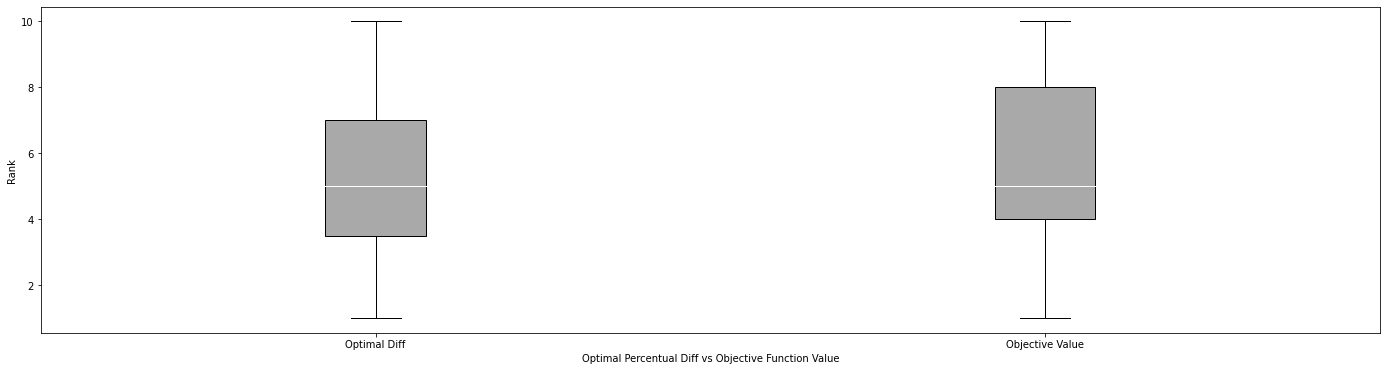

In [6]:
df = rank_executions("./acotsp_optimal_exp/")
a = [col for col in df.columns if 'opt' in col]
b = [col for col in df.columns if 'obj' in col]

df_r = pd.lreshape(df, {'Optimal Diff' : a, 'Objective Value' : b})
df_r
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df_r, "Optimal Percentual Diff vs Objective Function Value", False)



In [13]:

# compare samples
args = tuple(df[conf] for conf in df)

stat, p = friedmanchisquare(*args)

# interpret
alpha = 0.05
if p < alpha:
    # Different distributions (reject H0)
    posthoc_matrix = sp.posthoc_conover(
        pd.melt(df, var_name="configuration", value_name="rank"),
        val_col="rank",
        group_col="configuration",
        p_adjust="holm",
    )
    different_dists = posthoc_matrix.index[
        posthoc_matrix[df.sum().idxmax()] < 0.05
    ].tolist()
    df.drop(different_dists, axis=1, inplace=True)

df

,opt_diff_1,obj_func_3,opt_diff_5,opt_diff_3
d1655-465.txt_0,-2.0,-3.0,-7.0,-1.0
vm1748-468.txt_0,-3.0,-2.0,-7.0,-6.0
rl1304-466.txt_0,-3.0,-4.0,-6.0,-2.0
pr124-465.txt_0,-5.5,-5.5,-5.5,-5.5
kroB150-469.txt_0,-3.5,-3.5,-3.5,-9.0
...,...,...,...,...
p654-466.txt_0,-1.0,-7.0,-10.0,-3.0
pr124-468.txt_0,-5.5,-5.5,-5.5,-5.5
kroB200-466.txt_0,-3.0,-6.0,-3.0,-3.0
vm1748-465.txt_0,-5.0,-2.0,-6.0,-4.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

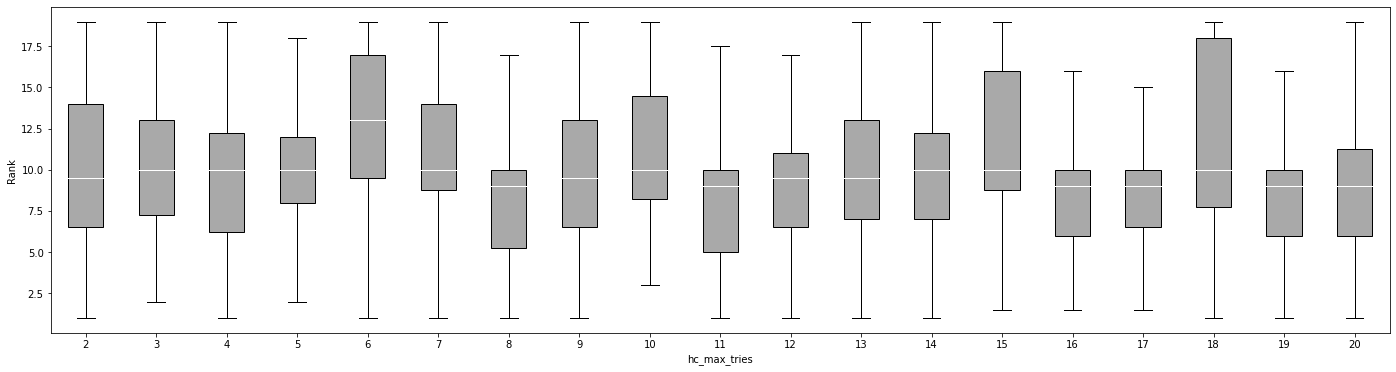

In [13]:
df = rank_executions("./acotsp_hc_max_tries_exp/")
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "hc_max_tries", False)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

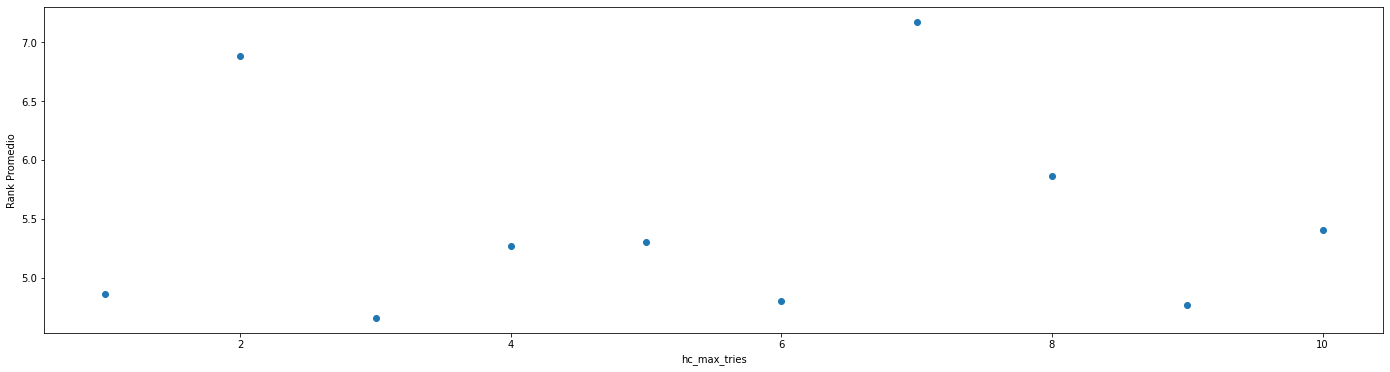

In [12]:
df = rank_executions("./acotsp_nseeds_exp/")
scatter_plot_executions(df, "hc_max_tries", False)
#boxplot_executions(df, "n_seeds", False)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

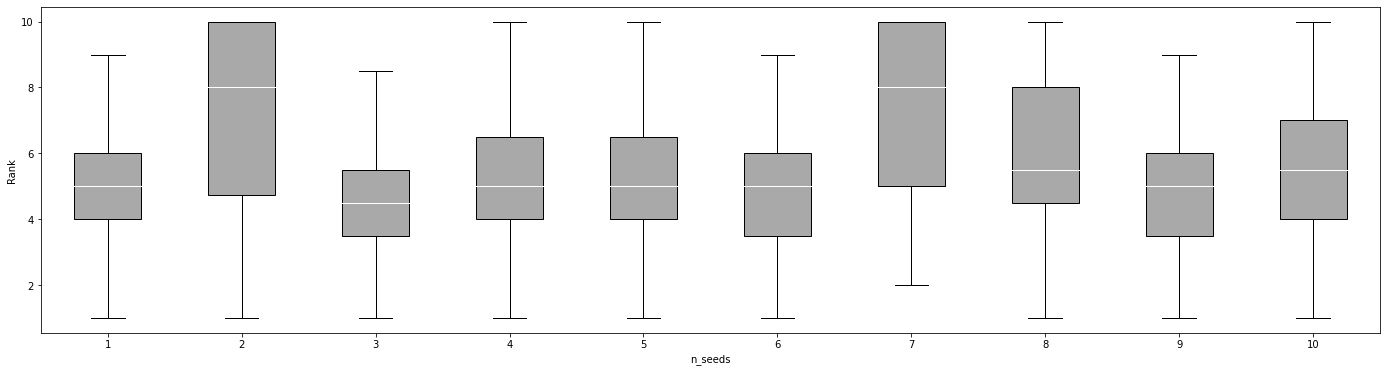

In [98]:
df = rank_executions("./acotsp_nseeds_exp/")
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "n_seeds", False)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

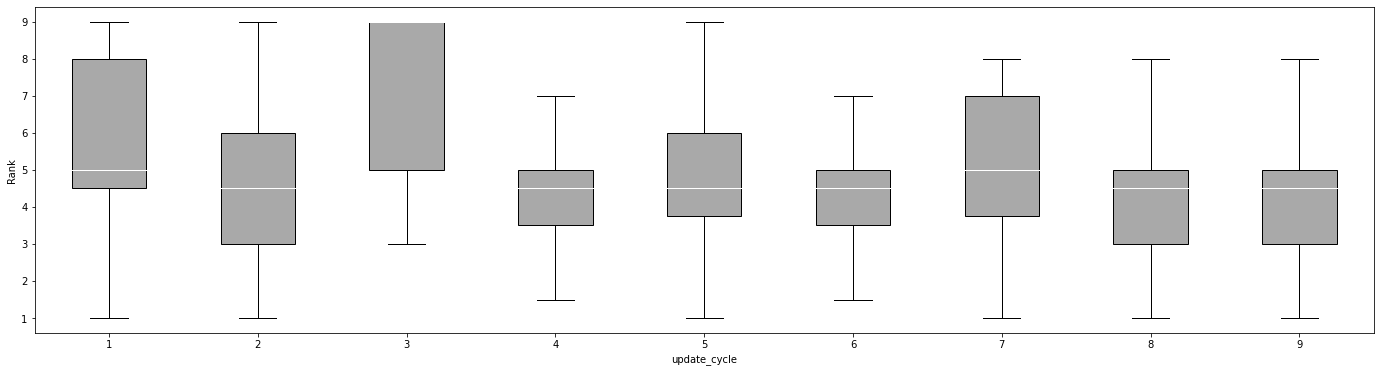

In [5]:
df = rank_executions("./acotsp_updatecycle_exp/")
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "update_cycle", False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

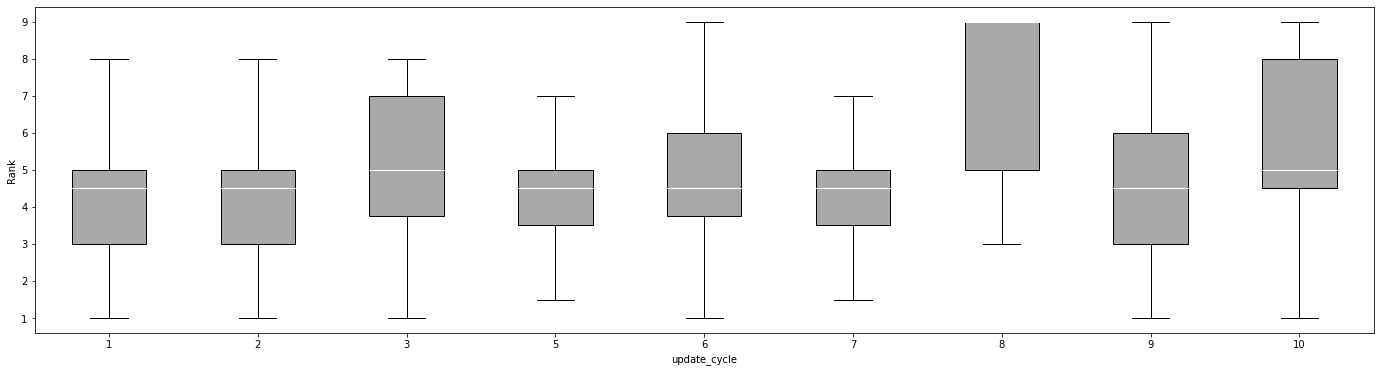

In [7]:
df = rank_executions("./acotsp_updatecycle_exp/")
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "update_cycle", False)

In [87]:
# compare samples
args = tuple(df[conf] for conf in df)

stat, p = friedmanchisquare(*args)

# interpret
alpha = 0.05
if p < alpha:
    # Different distributions (reject H0)
    posthoc_matrix = sp.posthoc_conover(
        pd.melt(df, var_name="configuration", value_name="rank"),
        val_col="rank",
        group_col="configuration",
        p_adjust="holm",
    )
    different_dists = posthoc_matrix.index[
        posthoc_matrix[df.sum().idxmax()] < 0.05
    ].tolist()
    df_final = df.drop(different_dists, axis=1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

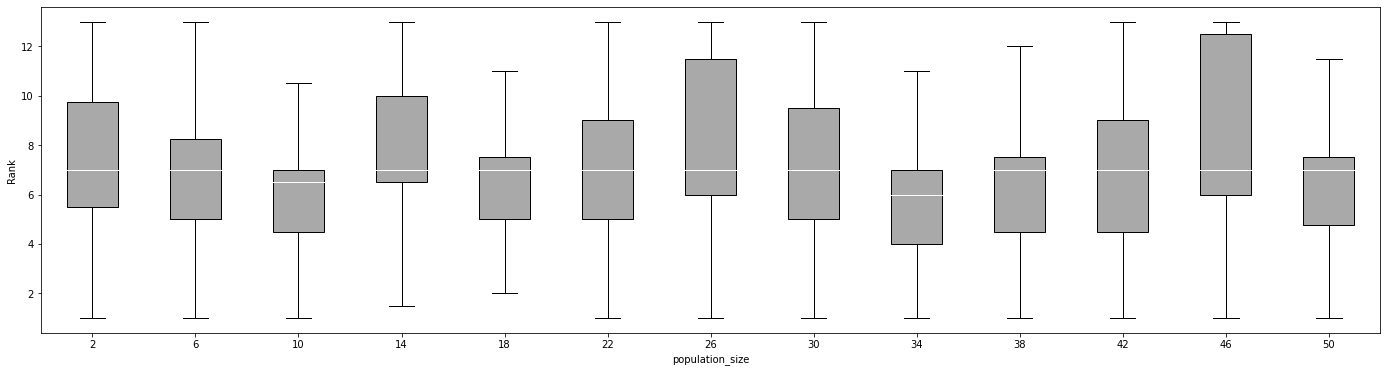

In [5]:
df = rank_executions("./acotsp_population_exp/")
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "population_size", False)

In [12]:
[file for file in sorted(os.listdir("./acotsp_updatecycle_exp")) if ".txt" in file]

['update_cycle_1_4671.txt',
 'update_cycle_2_4290.txt',
 'update_cycle_3_4077.txt',
 'update_cycle_4_4093.txt',
 'update_cycle_5_4062.txt',
 'update_cycle_6_4164.txt',
 'update_cycle_7_4137.txt',
 'update_cycle_8_4047.txt',
 'update_cycle_9_4225.txt']

In [46]:
a = [
	("hc_max_tries", 2, 3970),
	("hc_max_tries", 3, 4341),
	("hc_max_tries", 4, 4494),
	("hc_max_tries", 5, 4537),
	("hc_max_tries", 6, 4396),
	("hc_max_tries", 7, 4898),
	("hc_max_tries", 8, 4442),
	("hc_max_tries", 9, 5031),
	("hc_max_tries", 10, 4681),
	("hc_max_tries", 11, 4857),
	("hc_max_tries", 12, 4628),
	("hc_max_tries", 13, 4472),
	("hc_max_tries", 14, 4535),
	("hc_max_tries", 15, 4602),
	("hc_max_tries", 16, 4580),
	("hc_max_tries", 17, 4572),
	("hc_max_tries", 18, 4463),
	("hc_max_tries", 19, 4687),
	("hc_max_tries", 20, 4261),
]





b = [
	("hc_p_worse", 0.0, 4844),
	("hc_p_worse", 0.1, 4860),
	("hc_p_worse", 0.2, 4388),
	("hc_p_worse", 0.3, 4183),
	("hc_p_worse", 0.4, 4305),
	("hc_p_worse", 0.5, 4174),
	("hc_p_worse", 0.6, 4303),
	("hc_p_worse", 0.7, 4154),
	("hc_p_worse", 0.8, 4063),
	("hc_p_worse", 0.9, 4063),
	("hc_p_worse", 1.0, 4645),
]


c = [
	("n_seeds", 1, 2114),
	("n_seeds", 2, 2476),
	("n_seeds", 3, 3035),
	("n_seeds", 4, 3658),
	("n_seeds", 5, 4531),
	("n_seeds", 6, 5168),
	("n_seeds", 7, 6298),
	("n_seeds", 8, 7139),
	("n_seeds", 9, 7034),
	("n_seeds",10, 7950),
]

d = [
	("population_size", 2, 5412),
	("population_size", 6, 5717),
	("population_size", 10, 4837),
	("population_size", 14, 5224),
	("population_size", 18, 5370),
	("population_size", 22, 5200),
	("population_size", 26, 4376),
	("population_size", 30, 4454),
	("population_size", 34, 4072),
	("population_size", 38, 4713),
	("population_size", 42, 4301),
	("population_size", 46, 4829),
	("population_size", 50, 4234),
]


e = [
	("update_cycle", 1, 4671),
	("update_cycle", 2, 4290),
	("update_cycle", 3, 4077),
	("update_cycle", 4, 4093),
	("update_cycle", 5, 4062),
	("update_cycle", 6, 4164),
	("update_cycle", 7, 4137),
	("update_cycle", 8, 4047),
]


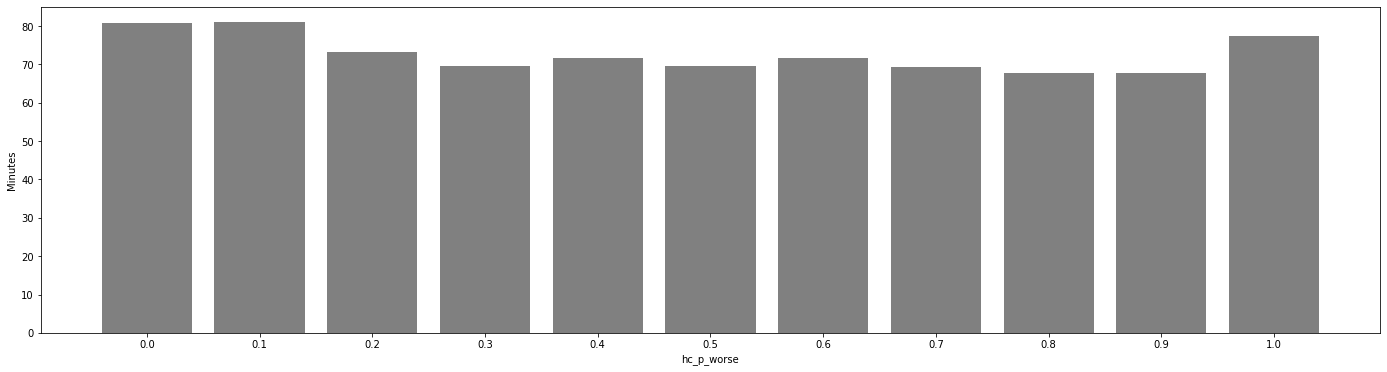

In [169]:
def scatter_time(data):
	name, x, y = list(zip(*data))
	name = name[0]
	plt.xlabel(name)
	plt.ylabel("Minutes")
	s = [100 for n in range(len(x))]
	y = [a/60 for a in y]
	plt.scatter(x,y,s, color="black", marker="s")
	plt.xticks(x, x)


def bar_time(data):
	name, x, y = list(zip(*data))
	name = name[0]
	plt.xlabel(name)
	plt.ylabel("Minutes")
	y = [a/60 for a in y]
	plt.bar(x,y,tick_label=x, color="grey")

def hist_time(data):
	name, x, y = list(zip(*data))
	name = name[0]
	plt.xlabel(name)
	plt.ylabel("Minutes")
	y = [a/60 for a in y]
	a = range(1,len(x)+1)
	plt.bar(a,y,color="grey")
	plt.xticks(a, x)
hist_time(b)


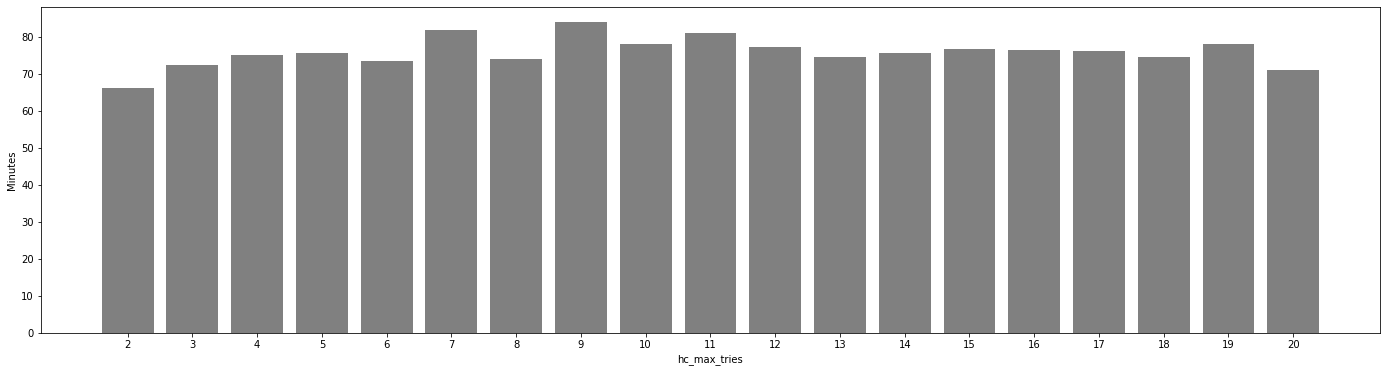

In [153]:
bar_time(a)

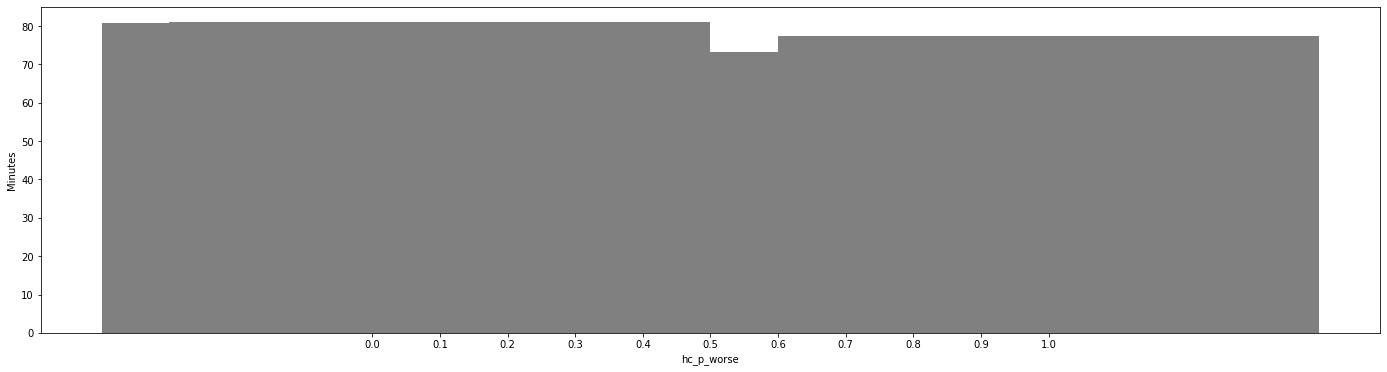

In [154]:
bar_time(b)

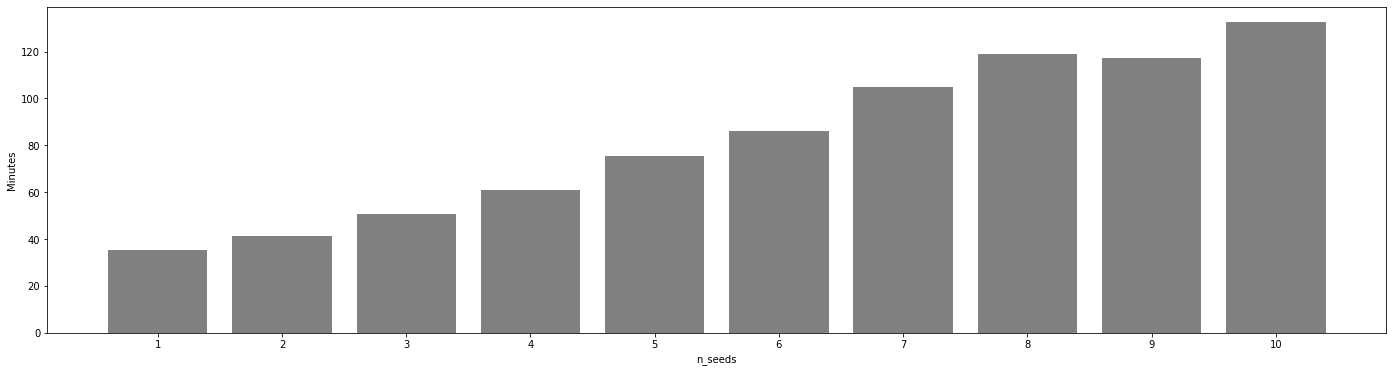

In [155]:
bar_time(c)

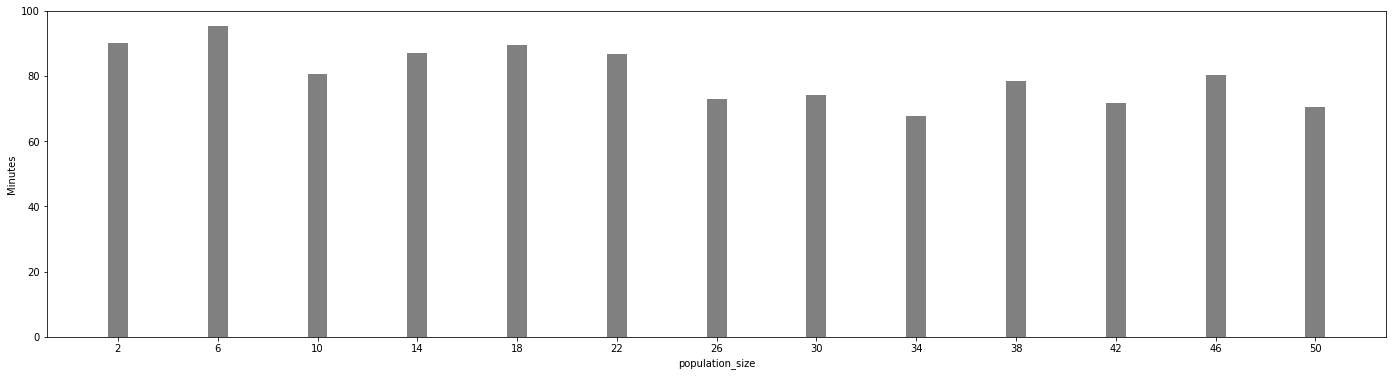

In [156]:
bar_time(d)

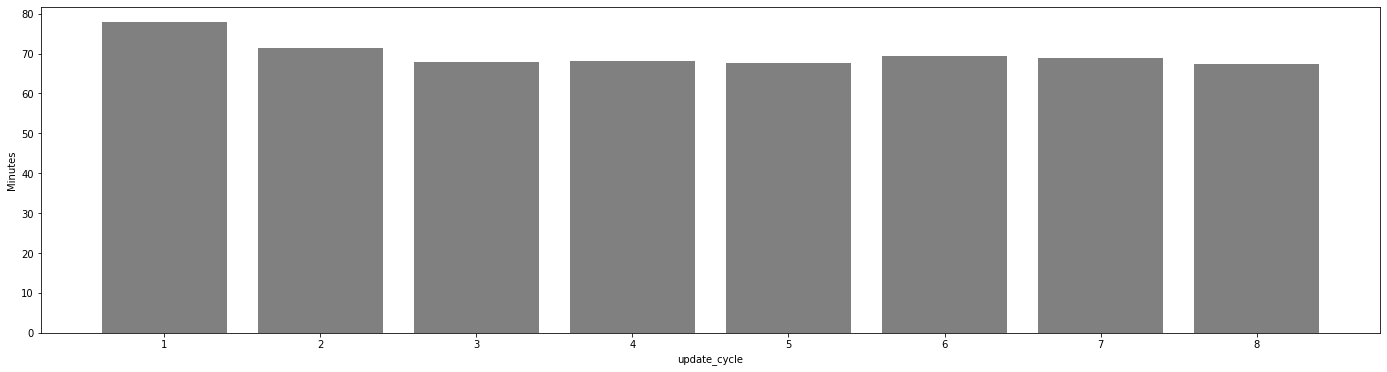

In [157]:
bar_time(e)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

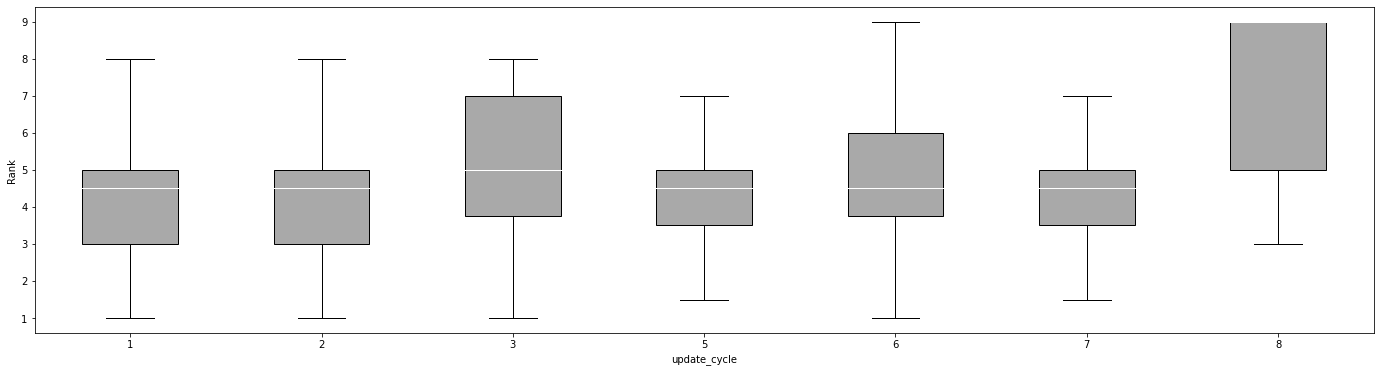

In [193]:
def boxplot_executions2(df, xlabel, xrotate):
	x = df.columns
	y = [-1*df[a] for a in df]

	plt.rcParams["figure.figsize"] = (24,6)
	if xrotate:
		plt.xticks(rotation=90)
	plt.xlabel(xlabel)
	plt.ylabel("Rank")

	a = plt.boxplot(y, labels=x, patch_artist=True, showfliers=False)

	for label, box in zip(x,a["boxes"]):
		box.set_facecolor("darkgray")

	for median in a['medians']:
		median.set_color('white')
		
	return plt

df = rank_executions("./acotsp_updatecycle_exp/")
df=df.drop(columns=["9","10"])
#scatter_plot_executions(df, "hc_max_tries", False)
boxplot_executions(df, "update_cycle", False)


In [178]:
a=[1,2,3,4,6,7,5]

In [179]:
a[:-2]

[1, 2, 3, 4, 6]